# PI curves
Following Romano-Thrane 2013

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
c= 299792458.
G=6.67408e-11 
pc_to_light_year = 3.26156  
pc_to_m = pc_to_light_year*c*86400*365.25
H0 = 67.9*1000/(1000000*pc_to_m)
print(pc_to_m, H0)

3.085674008015063e+16 2.2004916858886974e-18


In [2]:
# Parameters for matplotlib (these should be the same as the ones used for SHD)
fontsize = 20
matplotlib.rcParams.update({
    "font.size": fontsize,
    "axes.titlesize": fontsize,
    "axes.labelsize": fontsize, #* 2,
    "xtick.labelsize": fontsize,
    "ytick.labelsize": fontsize,
    "xtick.major.size": fontsize * .8,
    "ytick.major.size": fontsize * .8,
    "legend.fontsize": fontsize/2-1,
    #"font.family": "Times new Roman",
    "figure.dpi": 100,
    "savefig.dpi": 300,
    "text.usetex": True,
    "path.simplify": True,
    "figure.figsize": (8, 6)
})

plt.rcParams["figure.facecolor"] = "w"


# Class to deal in an easy way with number of digits in colorbars (used for ULs and sigma maps)
class FormatScalarFormatter(matplotlib.ticker.ScalarFormatter):
            def __init__(self, fformat="%1.1f", offset=True, mathText=True):
                self.fformat = fformat
                matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,
                                                        useMathText=mathText)
            def _set_format(self):
                self.format = self.fformat
                if self._useMathText:
                    #self.format = '$%s$' % matplotlib.ticker._mathdefault(self.format)
                    self.format = '$%s$' % ('\\mathdefault{%s}' % self.format)

## Reproducing Romano-Thrane

Following the prescriptions from the (2013)[https://journals.aps.org/prd/pdf/10.1103/PhysRevD.88.124032] paper, we try to reproduce the aligo HL PI curve (not sure which PSD wa used in 2013, hence there may be some differences).

### Check PSD->use aligo_design!
Use the one with a broader frequency range. (Frequencies need to be interpolated to the one of the ORF files, unless you evaluate them with some package here)

0.00812539999999995


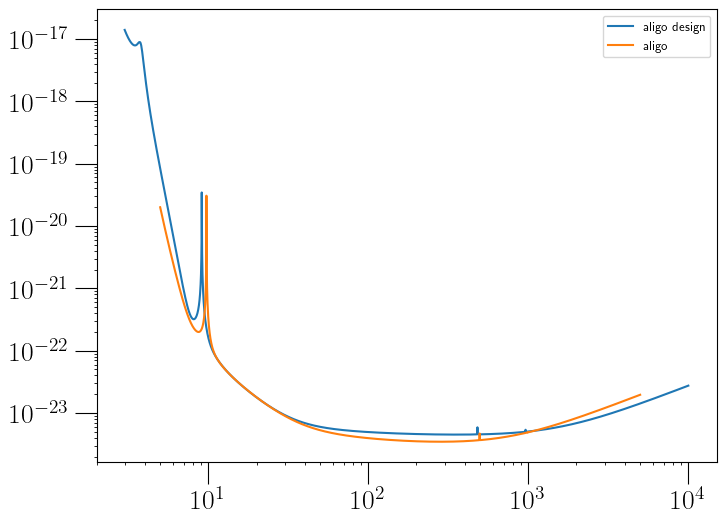

In [3]:
aligo_design = "/home/delillo/Desktop/PhD/Detector_curves/aligo_design.txt"
aligo = "/home/delillo/Desktop/PhD/Detector_curves/aligo.txt"

f_aligo_design, asd_aligo_design = np.transpose(np.loadtxt(aligo_design))
f_aligo, asd_aligo = np.transpose(np.loadtxt(aligo))
print(f_aligo_design[1]-f_aligo_design[0])

plt.loglog(f_aligo_design, asd_aligo_design, label = "aligo design")
plt.loglog(f_aligo, asd_aligo, label = "aligo")

plt.legend()
plt.show()

In [4]:
def Omega_f_PSD(f, psd):
    return 2*np.pi**2/(3*H0**2)*f**3*psd

def Omega_f_ASD(f, asd):
    return 2*np.pi**2/(3*H0**2)*f**3*asd**2

Naive $\Omega_{\mathrm{gw}}(f)$ sensitivity from aligo ASD, labelled with $\Omega_{\mathrm{aLIGO}} = \frac{2\pi^2}{3H_0^2}f^{3} (\mathrm{ASD_{aLIGO}})^2$.

This plot will be updated with may other curves, but we can already see that the curve already differs from the one of Romano-Thrane, givent that the current foreseen aLIGO differs from the 2013 forecast.

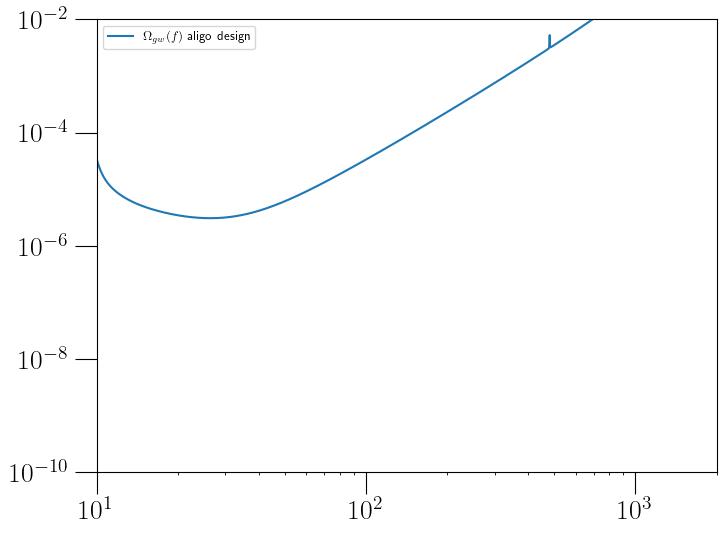

In [5]:
Om_aligo_design = Omega_f_ASD(f_aligo_design, asd_aligo_design)
#plt.loglog(f_aligo_design, asd_aligo_design, label = "aligo design")
plt.loglog(f_aligo_design, Om_aligo_design, label = r"$\Omega_{gw}(f)$ aligo design")

plt.xlim(10,2000)
plt.ylim(1e-10,1e-2)
plt.legend()
plt.show()

In [6]:
def PI_mine(freqs, Om_eff, obs_time = 365.25*86400, snr = 1, fref = 25.):
    """
    This function evaluates the PI curve,
    for a fixed observation time, snr, and fref.
    Om_eff spectrum needs to be evaluated a prior,
    and it is assumed to be a linspace.
    """
    
    def integrand(beta):
        return ((freqs/fref)**(2*beta))/(Om_eff**2)
    betas = np.arange(-10, 10.1, 1)#np.arange(-10, 10.1, 0.1)
    Om_beta = snr/(np.sqrt(2*obs_time))/np.sqrt(np.array([np.trapz(integrand(beta), freqs) for beta in betas]))
    Om_PI = np.array([np.max(Om_beta*(f/fref)**betas) for f in freqs])
    #for Om_b, beta in zip(Om_beta, betas):
    #    plt.loglog(freqs, Om_b*(freqs/fref)**beta)
    #plt.show()
    #plt.close()
    #print(Om_beta*(25/fref)**betas)
    #print(np.shape(Om_PI))
    
    return(Om_PI, Om_beta, betas)

In [7]:
path_to_det = "/home/delillo/Desktop/PhD/Detector_curves/"
detectors = ["aligo", "avirgo", "et", "ce"]
detectors_asds = {"aligo": path_to_det + "aligo.txt",\
                 "avirgo": path_to_det + "advirgo.txt",\
                 "et": path_to_det +"et_d.txt", \
                 "ce": path_to_det +"ce1.txt", "kagra": path_to_det+"kagra.txt",\
                 "aligo+":path_to_det + "aplus.txt",\
                 "avirgosqz":path_to_det + "advirgo_sqz.txt"}
colors = {"aligo": "blue", "avirgo": "red", "et" : "black", "ce": "purple", "kagra": "green"}

Loading aLIGO_ASD and HL_ORF, interpolate them to the frequencies considered in Romano-Thrane ($df=0.25$ Hz, $T=1$ yr, SNR=1)

/home/delillo/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


[] []
[] []


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


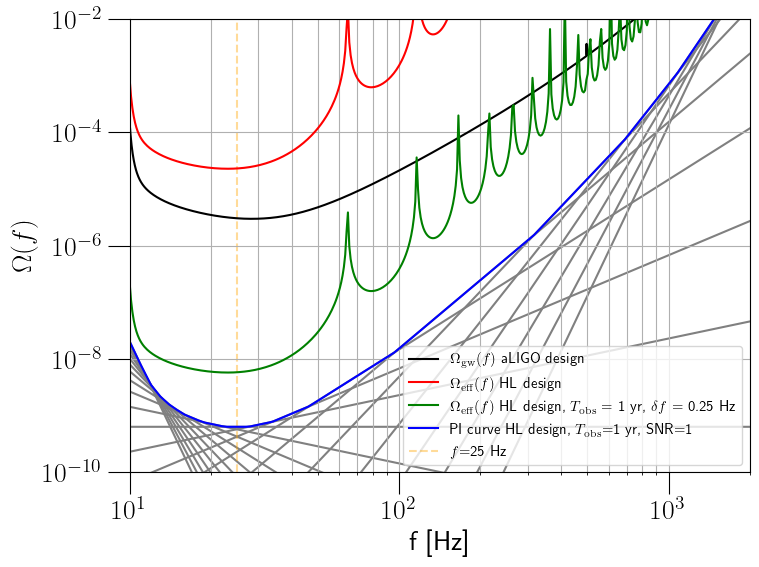

In [20]:
f, asd_H = np.transpose(np.loadtxt(detectors_asds["aligo"]))
OM = 2*np.pi**2/(3*H0**2)*f**3*asd_H**2

plt.loglog(f, OM, label = r"$\Omega_{\rm gw}(f)$ aLIGO design", color = "black")

ORF_HL_nside_16 = np.load("ORF_full_healpy_nside_128.npz")#np.load("ORF_HL_16.npz")
ff = ORF_HL_nside_16["freqs"]
ORF_HL = ORF_HL_nside_16["ORF_HL"]#["ORF_HL_small"]
#ff, ORF_HL = np.transpose(np.loadtxt("ORF_HL.txt"))

f_pi = np.linspace(10,2000, 1990+1)#np.linspace(1,1726, 1725*4+1)

asd_H_for_Om_eff = interp1d(f, asd_H, fill_value="extrapolate")(ff)

S_HL_eff = np.power(ORF_HL**2/(asd_H_for_Om_eff**4), -0.5)*5
OM_eff_HL = 2*np.pi**2/(3*H0**2)*ff**3*S_HL_eff

plt.loglog(ff, OM_eff_HL, label = r"$\Omega_{\rm eff}(f)$ HL design", color = "red")
plt.loglog(ff, OM_eff_HL/(np.sqrt(2*365.25*86400*0.25)), label = r"$\Omega_{\rm eff}(f)$ HL design, $T_{\rm obs}$ = 1 yr, $\delta f$ = 0.25 Hz", color = "green")

OM_eff_HL_pi = interp1d(ff, OM_eff_HL, fill_value="extrapolate")(f_pi)
obs_time = 365.25*86400
snr = 1
fref = 25.
PI_curve_HL, OM_betas, betas = np.transpose(PI_mine(f_pi, OM_eff_HL_pi, obs_time = obs_time, snr = snr, fref = fref))

print(betas[(2.4<betas)&(betas<2.5)], OM_betas[(2.4<betas)&(betas<2.5)]*(25./fref)**(2.5))
print(betas[(8.4<betas)&(betas<8.5)], OM_betas[(8.4<betas)&(betas<8.5)]*(25./fref)**(8.5))
plt.vlines(fref, 1e-10,1e-2, color = "orange", linestyle = "dashed", zorder=0, linewidth=1.5, alpha = 0.4, label = r"$f$"+f"={int(fref)} Hz")
plt.loglog(f_pi, PI_curve_HL, label = r"PI curve HL design, $T_{\rm obs}$=1 yr, SNR=1", color = "blue")

for beta, OM_beta in zip(betas, OM_betas):
    plt.loglog(f_pi, OM_beta*np.power(f_pi/fref, beta), color = "gray", zorder=-1 )
plt.xlabel("f [Hz]")
plt.ylabel(r"$\Omega(f)$")
plt.xlim(10,2000)
plt.ylim(1e-10,1e-2)
plt.grid(which = "both")
plt.savefig("./PI_curve_HL_no_legend.pdf", bbox_inches = "tight")
plt.legend(loc="lower right", fontsize = 10.65)
#plt.savefig("Romano-Trane_Fig3.png", dpi = 300)
plt.savefig("./PI_curve_HL.svg", bbox_inches = "tight")
plt.savefig("./PI_curve_HL.pdf", bbox_inches = "tight")
plt.savefig("./PI_curve_HL.eps", bbox_inches = "tight")
plt.show()

In [9]:
OM_betas_25 = OM_betas*(25./fref)**(betas)
OM_betas_25_interpolator = interp1d(betas, OM_betas_25)

betas_to_check=[-1, 0., 2./3, 4./3, 5./3, 2, 2.5, 3, 4, 7, 8.5]
print(OM_betas_25_interpolator(betas_to_check))

np.savez("./minimum_detectable_om_alpha_from_aLIGO_HL_PI_curve_25Hz_1yr_SNR1.npz", alphas = betas, Om_ref=OM_betas)

[5.70225924e-10 6.31829166e-10 5.92159757e-10 5.22567029e-10
 4.72809006e-10 4.23050983e-10 3.26099574e-10 2.29148164e-10
 5.95961467e-11 4.00342546e-15 3.36580494e-17]


## ORFs and ASDs

Loading data

In [10]:
ORFs_data = np.load("ORF_full_healpy_nside_128.npz")#np.load("ORF_small_healpy_nside_32.npz")

f_ORF = ORFs_data["freqs"]
f_L, asd_L = np.transpose(np.loadtxt(detectors_asds["aligo"]))
f_V, asd_V = np.transpose(np.loadtxt(detectors_asds["avirgo"]))
f_K, asd_K = np.transpose(np.loadtxt(detectors_asds["kagra"]))

ORF_HL = ORFs_data["ORF_HL"]

ORF_HV = ORFs_data["ORF_HV"]
ORF_LV = ORFs_data["ORF_LV"]

ORF_HK = ORFs_data["ORF_HK"]
ORF_LK = ORFs_data["ORF_LK"]
ORF_VK = ORFs_data["ORF_VK"]

ORF_HI = ORFs_data["ORF_HI"]
ORF_LI = ORFs_data["ORF_LI"]
ORF_VI = ORFs_data["ORF_VI"]
ORF_KI = ORFs_data["ORF_KI"]

Reconditioning data to same frequencies

In [11]:
f_pi = np.linspace(10,2000, 1990+1)

asd_L_pi = interp1d(f_L, asd_L, fill_value="extrapolate")(f_pi)
asd_V_pi = interp1d(f_V, asd_V, fill_value="extrapolate")(f_pi)
asd_K_pi = interp1d(f_K, asd_K, fill_value="extrapolate")(f_pi)

ORF_HL_pi = interp1d(f_ORF, ORF_HL, fill_value="extrapolate")(f_pi)

ORF_HV_pi = interp1d(f_ORF, ORF_HV, fill_value="extrapolate")(f_pi)
ORF_LV_pi = interp1d(f_ORF, ORF_LV, fill_value="extrapolate")(f_pi)

ORF_HK_pi = interp1d(f_ORF, ORF_HK, fill_value="extrapolate")(f_pi)
ORF_LK_pi = interp1d(f_ORF, ORF_LK, fill_value="extrapolate")(f_pi)
ORF_VK_pi = interp1d(f_ORF, ORF_VK, fill_value="extrapolate")(f_pi)

ORF_HI_pi = interp1d(f_ORF, ORF_HI, fill_value="extrapolate")(f_pi)
ORF_LI_pi = interp1d(f_ORF, ORF_LI, fill_value="extrapolate")(f_pi)
ORF_VI_pi = interp1d(f_ORF, ORF_VI, fill_value="extrapolate")(f_pi)
ORF_KI_pi = interp1d(f_ORF, ORF_KI, fill_value="extrapolate")(f_pi)

Getting $S_{\mathrm{eff}}(f)$ and $\Omega_{\mathrm{eff}}(f)$

In [12]:
S_eff_HL = np.power(ORF_HL_pi**2/(asd_L_pi**4), -0.5)
OM_eff_HL = 2*np.pi**2/(3*H0**2)*f_pi**3*S_eff_HL*5

S_eff_HV = np.power(ORF_HV_pi**2/(asd_L_pi**2*asd_V_pi**2), -0.5)
S_eff_LV = np.power(ORF_LV_pi**2/(asd_L_pi**2*asd_V_pi**2), -0.5)

S_eff_HLV = np.power(S_eff_HL**-2 + S_eff_HV**-2+S_eff_LV**-2, -0.5)
OM_eff_HLV = 2*np.pi**2/(3*H0**2)*f_pi**3*S_eff_HLV*5

S_eff_HK = np.power(ORF_HK_pi**2/(asd_L_pi**-2*asd_K_pi**-2), -0.5)
S_eff_LK = np.power(ORF_LK_pi**2/(asd_L_pi**-2*asd_K_pi**-2), -0.5)
S_eff_VK = np.power(ORF_VK_pi**2/(asd_V_pi**-2*asd_K_pi**-2), -0.5)

S_eff_HLVK = np.power(S_eff_HLV**-2 + S_eff_HK**-2 + S_eff_LK**-2+S_eff_VK**-2, -0.5)
OM_eff_HLVK = 2*np.pi**2/(3*H0**2)*f_pi**3*S_eff_HLVK*5

S_eff_HI = np.power(ORF_HI_pi**2/(asd_L_pi**4), -0.5)
S_eff_LI = np.power(ORF_LI_pi**2/(asd_L_pi**4), -0.5)
S_eff_VI = np.power(ORF_VI_pi**2/(asd_V_pi**2*asd_L_pi**2), -0.5)
S_eff_KI = np.power(ORF_KI_pi**2/(asd_K_pi**2*asd_L_pi**2), -0.5)

S_eff_HLVKI = np.power(S_eff_HLVK**-2 + S_eff_HI**-2 + S_eff_LI**-2 + S_eff_VI**-2 + S_eff_KI**-2, -0.5)
OM_eff_HLVKI = 2*np.pi**2/(3*H0**2)*f_pi**3*S_eff_HLVKI*5

Getting PI curves

In [13]:
obs_time = 365.25*86400
snr = 1
fref = 100.

PI_curve_HL, _, _ = np.transpose(PI_mine(f_pi, OM_eff_HL, obs_time = obs_time, snr = snr, fref = fref))
PI_curve_HLV, _, _ = np.transpose(PI_mine(f_pi, OM_eff_HLV, obs_time = obs_time, snr = snr, fref = fref))
PI_curve_HLVK, _, _ = np.transpose(PI_mine(f_pi, OM_eff_HLVK, obs_time = obs_time, snr = snr, fref = fref))
PI_curve_HLVKI, _, _ = np.transpose(PI_mine(f_pi, OM_eff_HLVKI, obs_time = obs_time, snr = snr, fref = fref))

/home/delillo/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


## HL network

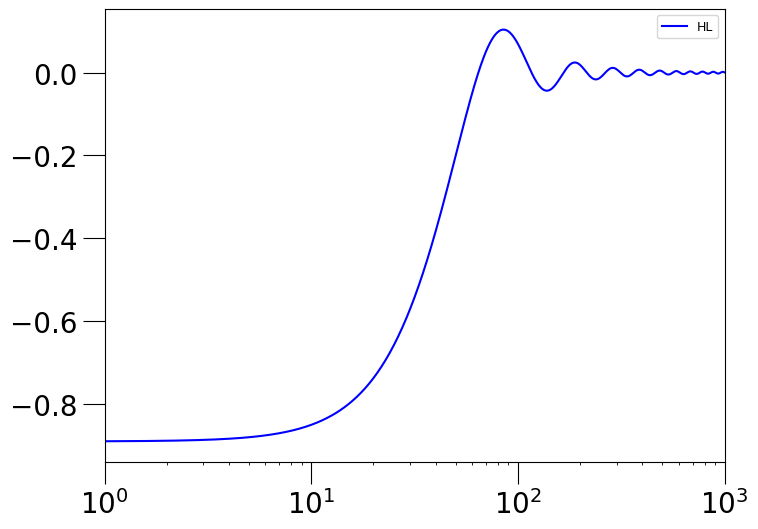

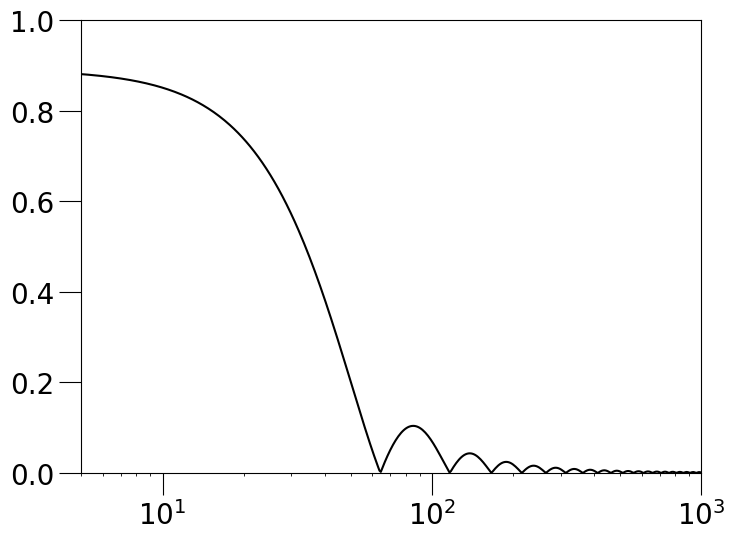

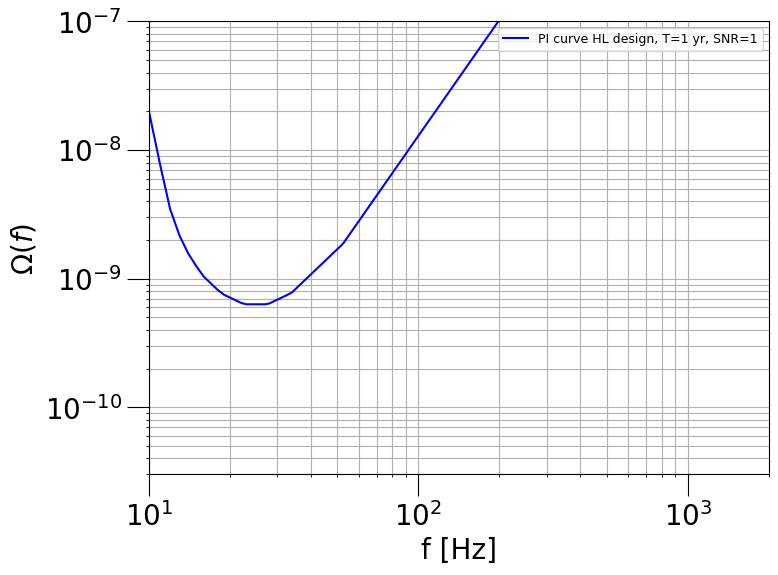

In [14]:
plt.plot(f_ORF, ORF_HL, color = "blue", label = "HL")
plt.xscale("log")
plt.xlim(1,np.max(f_ORF))
plt.legend()
plt.show()
plt.close()

plt.plot(f_ORF, np.sqrt(ORF_HL**2), color = "black")
plt.xscale("log")
plt.xlim(5, 1e3)
plt.ylim(0, 1)
plt.show()
plt.close()

plt.loglog(f_pi, PI_curve_HL, label = r"PI curve HL design, T=1 yr, SNR=1", color = "blue")
plt.xlabel("f [Hz]")
plt.ylabel(r"$\Omega(f)$")
plt.xlim(10,2000)
plt.ylim(3e-11,1e-7)
plt.grid(which = "both")
plt.legend()
plt.show()

## HLV network

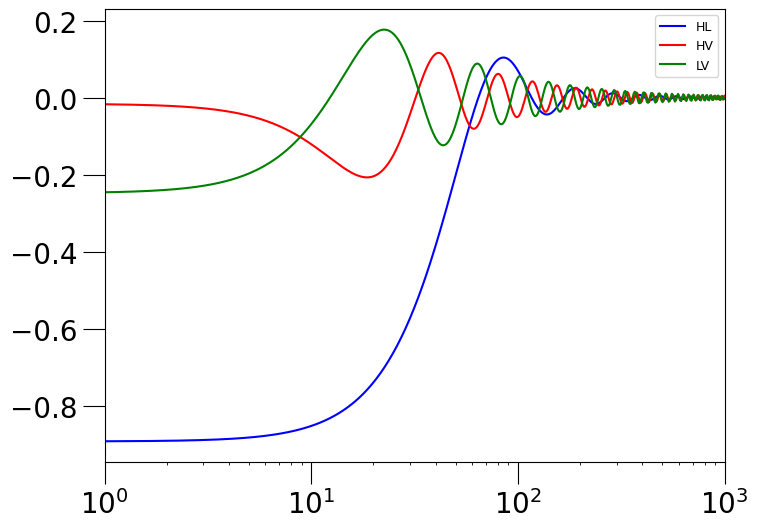

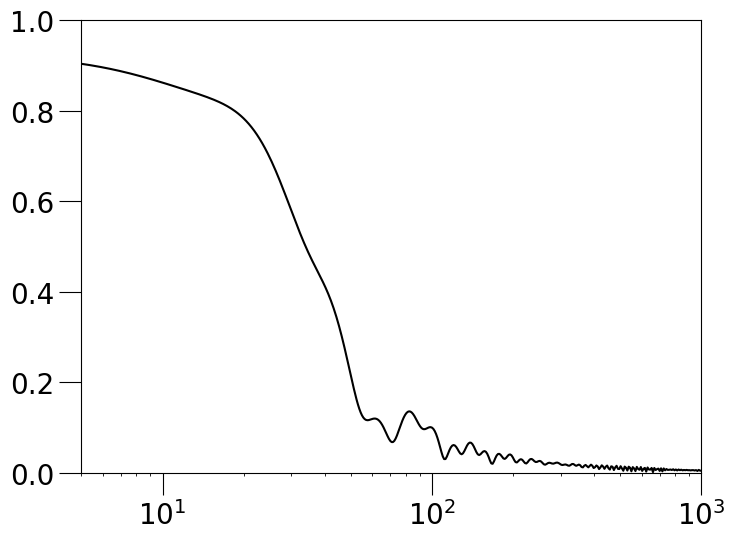

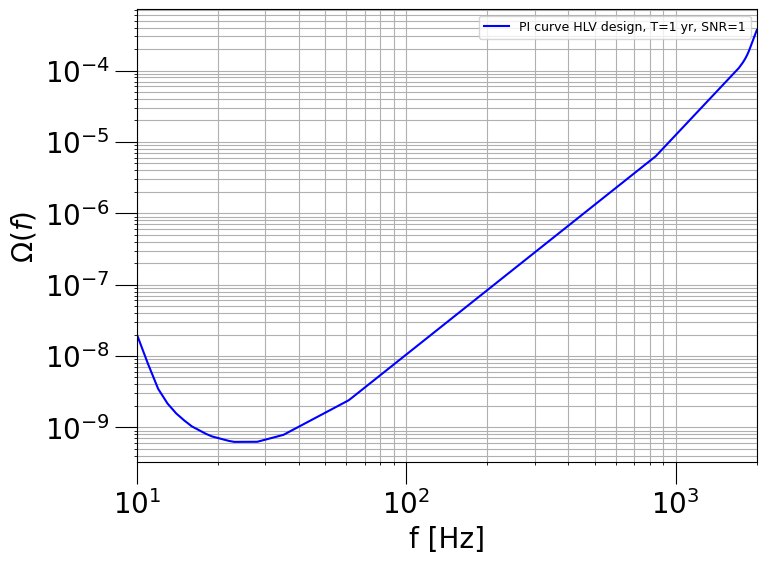

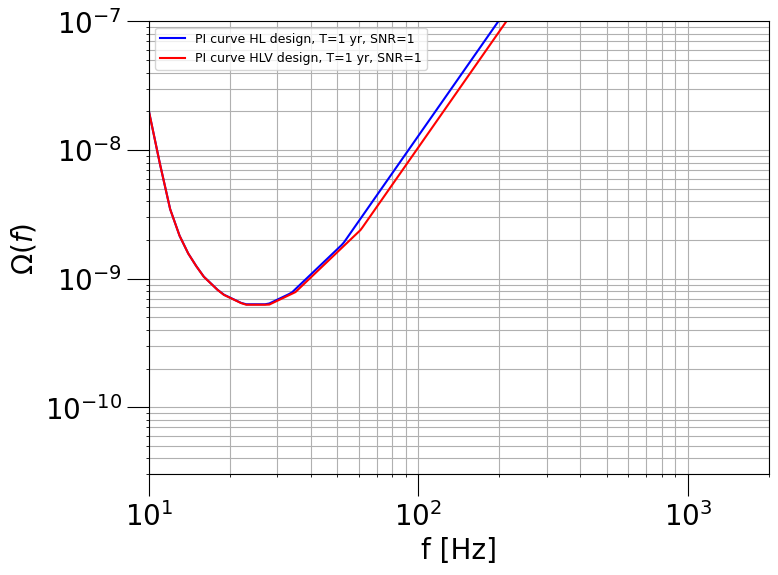

In [15]:
plt.plot(f_ORF, ORF_HL, color = "blue", label = "HL")
plt.plot(f_ORF, ORF_HV, color = "red", label = "HV")
plt.plot(f_ORF, ORF_LV, color = "green", label = "LV")
plt.xscale("log")
plt.xlim(1,np.max(f_ORF))
plt.legend()
plt.show()
plt.close()

plt.plot(f_ORF, np.sqrt(ORF_HL**2 + ORF_HV**2 + ORF_LV**2), color = "black")
plt.xscale("log")
plt.xlim(5, 1e3)
plt.ylim(0, 1)
plt.show()
plt.close()

plt.loglog(f_pi, PI_curve_HLV, label = r"PI curve HLV design, T=1 yr, SNR=1", color = "blue")
plt.xlabel("f [Hz]")
plt.ylabel(r"$\Omega(f)$")
plt.xlim(10,2000)
#plt.ylim(1e-10,1e-2)
plt.grid(which = "both")
plt.legend()
plt.show()

plt.loglog(f_pi, PI_curve_HL, label = r"PI curve HL design, T=1 yr, SNR=1", color = "blue")
plt.loglog(f_pi, PI_curve_HLV, label = r"PI curve HLV design, T=1 yr, SNR=1", color = "red")
plt.xlabel("f [Hz]")
plt.ylabel(r"$\Omega(f)$")
plt.xlim(10,2000)
plt.ylim(3e-11,1e-7)
plt.grid(which = "both")
plt.legend()
plt.show()

## HLVK network

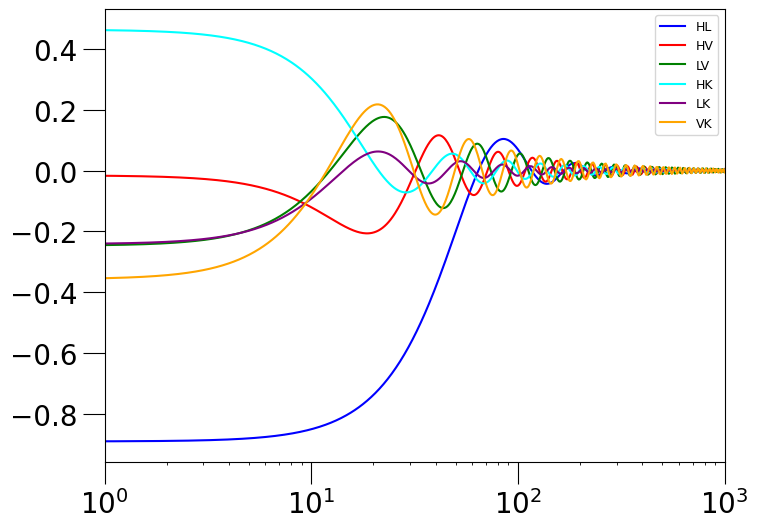

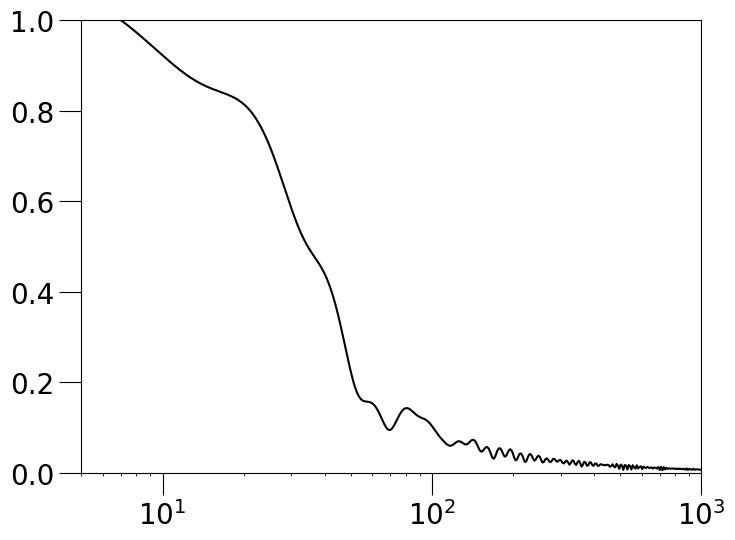

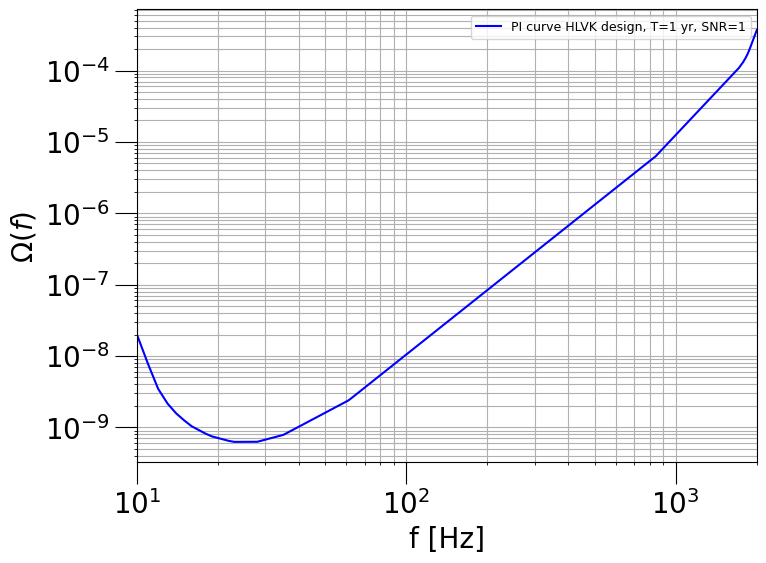

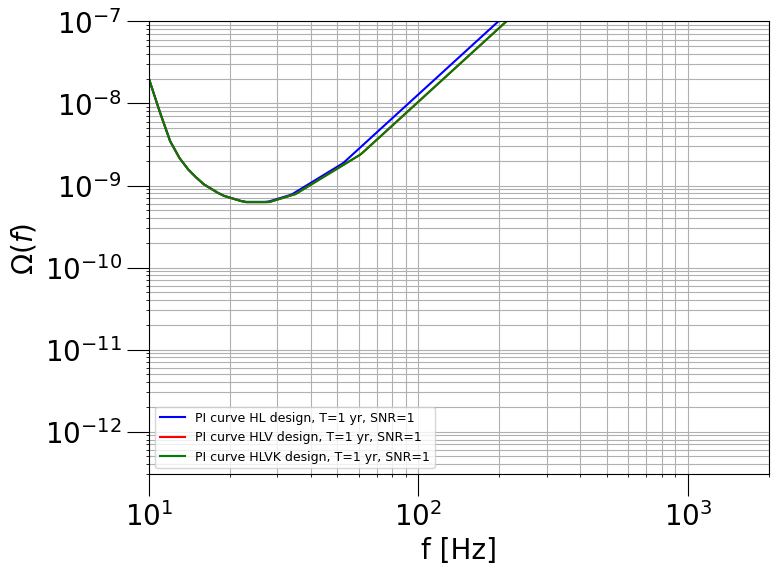

In [16]:
plt.plot(f_ORF, ORF_HL, color = "blue", label = "HL")
plt.plot(f_ORF, ORF_HV, color = "red", label = "HV")
plt.plot(f_ORF, ORF_LV, color = "green", label = "LV")
plt.plot(f_ORF, ORF_HK, color = "cyan", label = "HK")
plt.plot(f_ORF, ORF_LK, color = "purple", label = "LK")
plt.plot(f_ORF, ORF_VK, color = "orange", label = "VK")
plt.xscale("log")
plt.xlim(1,np.max(f_ORF))
plt.legend()
plt.show()
plt.close()


plt.plot(f_ORF, np.sqrt(ORF_HL**2 + ORF_HV**2 + ORF_LV**2 +\
                        ORF_HK**2 + ORF_LK**2 + ORF_VK**2), color = "black")
plt.xscale("log")
plt.xlim(5, 1e3)
plt.ylim(0, 1)
plt.show()
plt.close()

plt.loglog(f_pi, PI_curve_HLVK, label = r"PI curve HLVK design, T=1 yr, SNR=1", color = "blue")
plt.xlabel("f [Hz]")
plt.ylabel(r"$\Omega(f)$")
plt.xlim(10,2000)
#plt.ylim(1e-10,1e-2)
plt.grid(which = "both")
plt.legend()
plt.show()

plt.loglog(f_pi, PI_curve_HL, label = r"PI curve HL design, T=1 yr, SNR=1", color = "blue")
plt.loglog(f_pi, PI_curve_HLV, label = r"PI curve HLV design, T=1 yr, SNR=1", color = "red")
plt.loglog(f_pi, PI_curve_HLVK, label = r"PI curve HLVK design, T=1 yr, SNR=1", color = "green")
plt.xlabel("f [Hz]")
plt.ylabel(r"$\Omega(f)$")
plt.xlim(10,2000)
plt.ylim(3e-13,1e-7)
plt.grid(which = "both")
plt.legend()
plt.show()

## HLVKI network

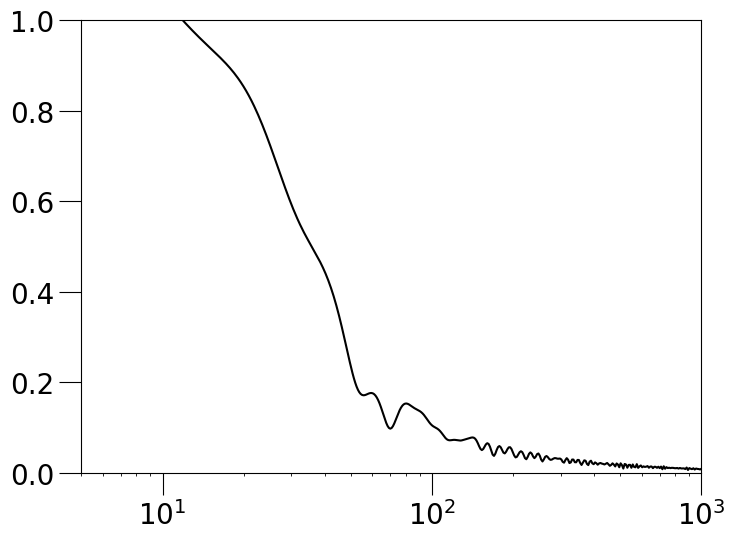

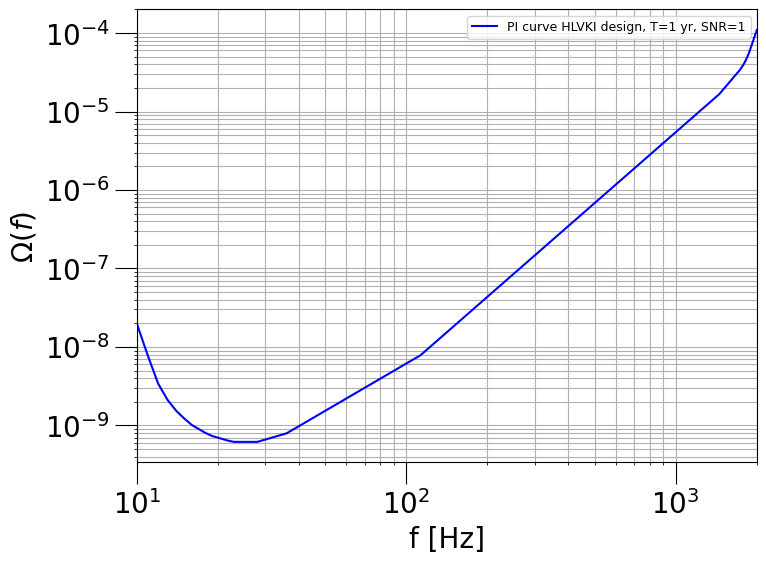

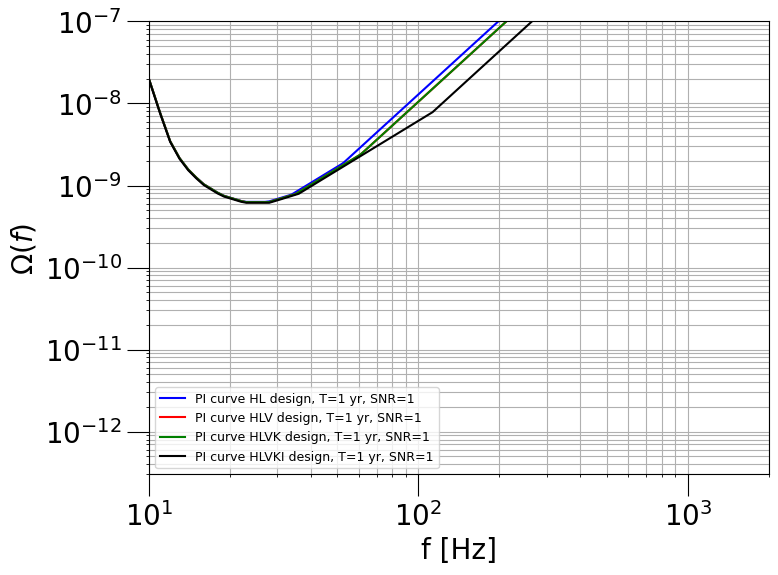

In [17]:
plt.plot(f_ORF, np.sqrt(ORF_HL**2 + ORF_HV**2 + ORF_LV**2 +\
                        ORF_HK**2 + ORF_LK**2 + ORF_VK**2 +\
                        ORF_HI**2 + ORF_LI**2 + ORF_VI**2 + ORF_KI**2), color = "black")
plt.xscale("log")
plt.xlim(5, 1e3)
plt.ylim(0, 1)
plt.show()
plt.close()

plt.loglog(f_pi, PI_curve_HLVKI, label = r"PI curve HLVKI design, T=1 yr, SNR=1", color = "blue")
plt.xlabel("f [Hz]")
plt.ylabel(r"$\Omega(f)$")
plt.xlim(10,2000)
#plt.ylim(1e-10,1e-2)
plt.grid(which = "both")
plt.legend()
plt.show()

plt.loglog(f_pi, PI_curve_HL, label = r"PI curve HL design, T=1 yr, SNR=1", color = "blue")
plt.loglog(f_pi, PI_curve_HLV, label = r"PI curve HLV design, T=1 yr, SNR=1", color = "red")
plt.loglog(f_pi, PI_curve_HLVK, label = r"PI curve HLVK design, T=1 yr, SNR=1", color = "green")
plt.loglog(f_pi, PI_curve_HLVKI, label = r"PI curve HLVKI design, T=1 yr, SNR=1", color = "black")
plt.xlabel("f [Hz]")
plt.ylabel(r"$\Omega(f)$")
plt.xlim(10,2000)
plt.ylim(3e-13,1e-7)
plt.grid(which = "both")
plt.legend()
plt.show()

# HL MDC 

/home/delillo/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


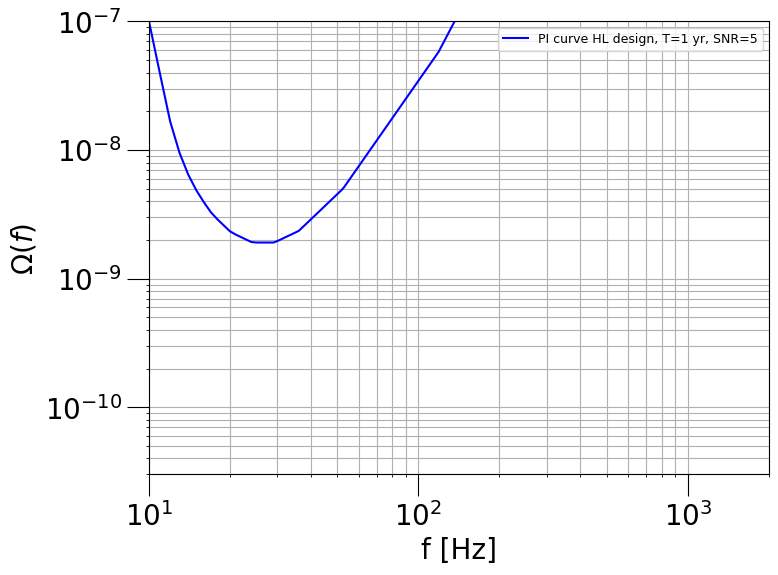

In [18]:
f, asd_H = np.transpose(np.loadtxt("aLIGO_MDC.txt"))
OM = 2*np.pi**2/(3*H0**2)*f**3*asd_H**2

#plt.loglog(f, OM, label = r"$\Omega_{gw}(f)$ aligo design", color = "black")

ORFs_data = np.load("ORF_full_healpy_nside_128.npz")#("ORF_small_healpy_nside_32.npz")
f_ORF = ORFs_data["freqs"]
ORF_HL = ORFs_data["ORF_HL"]
#f_L, asd_L = np.transpose(np.loadtxt(detectors_asds["aligo"]))


f_pi = np.linspace(10,2000, 1990+1)#np.linspace(1,1726, 1725*4+1)

asd_H_for_Om_eff = interp1d(f, asd_H, fill_value="extrapolate")(ff)

S_HL_eff = np.power(ORF_HL**2/(asd_H_for_Om_eff**4), -0.5)*5
OM_eff_HL = 2*np.pi**2/(3*H0**2)*ff**3*S_HL_eff

#plt.loglog(ff, OM_eff_HL, label = r"$\Omega_{eff}(f)$ HL design", color = "red")
#plt.loglog(ff, OM_eff_HL/(np.sqrt(2*365.25*86400*0.25)), label = r"$\Omega_{eff}(f)$ HL design, T = 1 yr, df = 0.25", color = "green")

OM_eff_HL_pi = interp1d(ff, OM_eff_HL, fill_value="extrapolate")(f_pi)
obs_time = 365.25*86400/2#365.25*86400*5
snr = 5#2
fref = 100.
PI_curve_HL, OM_betas, betas = np.transpose(PI_mine(f_pi, OM_eff_HL_pi, obs_time = obs_time, snr = snr, fref = fref))

#plt.vlines(fref, 1e-10,1e-2, color = "red", linestyle = "dashed", zorder=0, linewidth=1.5, alpha = 0.4)
plt.loglog(f_pi, PI_curve_HL, label = r"PI curve HL design, T=1 yr, SNR={}".format(str(snr)), color = "blue")

#for beta, OM_beta in zip(betas, OM_betas):
#    plt.loglog(f_pi, OM_beta*np.power(f_pi/fref, beta), color = "gray", zorder=-1 )
plt.xlabel("f [Hz]")
plt.ylabel(r"$\Omega(f)$")
plt.xlim(10,2000)
plt.ylim(3e-11,1e-7)
plt.grid(which = "both")
plt.legend()
plt.show()

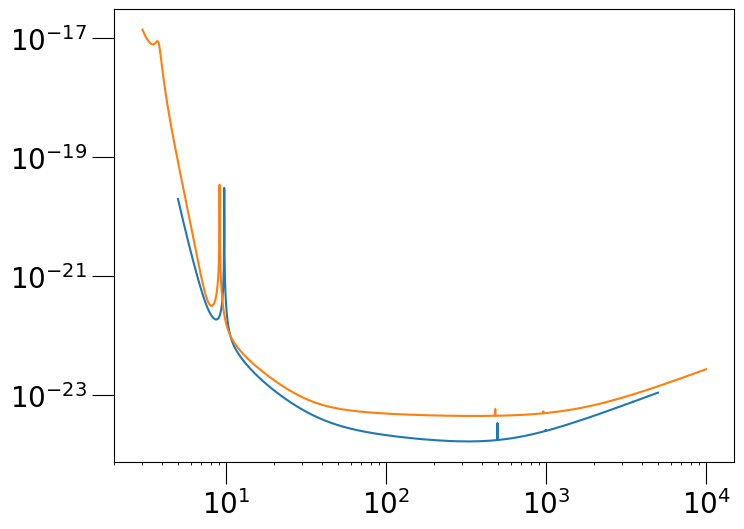

In [19]:
plt.loglog(f, asd_H)
plt.loglog(f_aligo_design, asd_aligo_design, label = "aligo design")
plt.show()

# PI SNR

In [20]:
def PI_SNR(freqs, Om_eff, obs_time = 365.25*86400, snr = 1, fref = 25., beta = 2./3, Om_beta = 6.9e-10):
    """
    This function evaluates the SNR evolution with
    the observation time,assuming an fref, a power-law beta and Om_beta.
    Om_eff spectrum needs to be evaluated a prior,
    and it is assumed to be a linspace.
    """
    
    def integrand(beta):
        return ((freqs/fref)**(2*beta))/(Om_eff**2)
    
    snr_t = Om_beta*(np.sqrt(2*obs_time))*np.sqrt(np.trapz(integrand(beta), freqs))
    
    return(snr_t)

In [21]:
#After GW170817 paper: https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.120.091101
obs_time = np.append(0, np.logspace(0, np.log10(86400*365.25*5), 1000))#86400*365.25#
Om_beta = 1.8e-9
Om_beta_up_factor = (Om_beta+2.7e-9)/Om_beta
Om_beta_down_factor = (Om_beta-1.3e-9)/Om_beta
beta = 2./3
#print(obs_time)
snr_t = PI_SNR(f_pi, OM_eff_HL_pi, obs_time = obs_time, fref = fref, beta = beta, Om_beta = Om_beta)
#print(snr_t)

For a power law Om_beta(100.0)=1.8e-09 with spectral index beta = 0.6666666666666666
Reaching SNR = 1 after 1.499712616003812 months of observation.
Reaching SNR = 3 after 1.1027259231683753 years of observation.
Reaching SNR = 5 after 3.059191879584294 years of observation.

For a power law Om_beta(100.0)=4.500000000000001e-09 with spectral index beta = 0.6666666666666666
Reaching SNR = 1 after 0.23988266248836984 months of observation.
Reaching SNR = 3 after 2.1474713063656234 months of observation.
Reaching SNR = 5 after 5.957533639182324 months of observation.



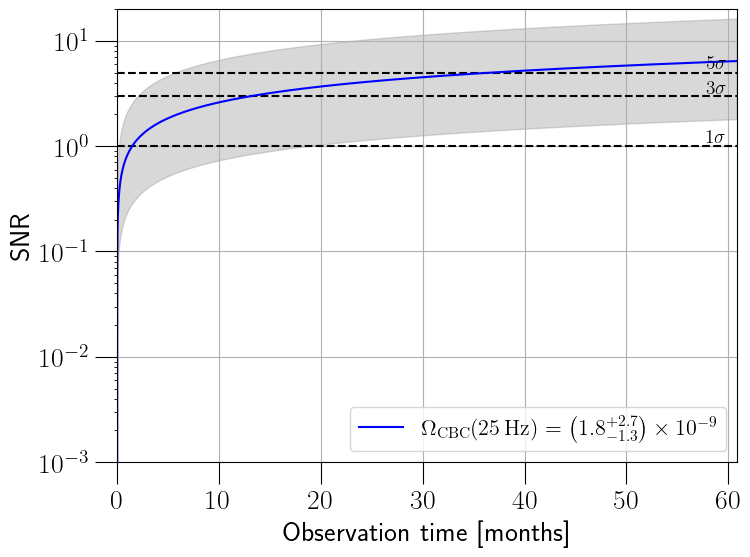

In [32]:
rescaled_obs_time = obs_time/86400/30

print(f"For a power law Om_beta({fref})={Om_beta} with spectral index beta = {beta}")
print(f"Reaching SNR = 1 after {(rescaled_obs_time[snr_t>1])[0]} months of observation.")
print(f"Reaching SNR = 3 after {(rescaled_obs_time[snr_t>3])[0]*30/365.25} years of observation.")
print(f"Reaching SNR = 5 after {(rescaled_obs_time[snr_t>5])[0]*30/365.25} years of observation.\n")


print(f"For a power law Om_beta({fref})={Om_beta*Om_beta_up_factor} with spectral index beta = {beta}")
print(f"Reaching SNR = 1 after {(rescaled_obs_time[snr_t*Om_beta_up_factor>1])[0]} months of observation.")
print(f"Reaching SNR = 3 after {(rescaled_obs_time[snr_t*Om_beta_up_factor>3])[0]} months of observation.")
print(f"Reaching SNR = 5 after {(rescaled_obs_time[snr_t*Om_beta_up_factor>5])[0]} months of observation.\n")

plt.plot(rescaled_obs_time, snr_t, color = "blue", label = r"$\Omega_{\mathrm{CBC}}(25\, {\rm Hz}) = \left(1.8^{+2.7}_{-1.3}\right)\times 10^{-9}$")
plt.fill_between(rescaled_obs_time, snr_t*Om_beta_up_factor, snr_t*Om_beta_down_factor, color = "gray", alpha = 0.3)
plt.hlines(1, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(3, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(5, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")

plt.annotate(r"$1\sigma$", (rescaled_obs_time[-1]*0.95, 1+0.1), textcoords='data', fontsize=14)
plt.annotate(r"$3\sigma$", (rescaled_obs_time[-1]*0.95, 3+0.2), textcoords='data', fontsize=14)
plt.annotate(r"$5\sigma$", (rescaled_obs_time[-1]*0.95, 5+0.5), textcoords='data', fontsize=14)
#plt.xscale("log")
plt.yscale("log")

plt.xlim(rescaled_obs_time[0], rescaled_obs_time[-1])
plt.ylim(1e-3, 20)
plt.xlabel("Observation time [months]")
plt.ylabel("SNR")
plt.grid()
plt.legend(fontsize = 20*0.8, loc="lower right")
plt.savefig("Predicting_Armageddon_plot_HL_GWTC-2.pdf", bbox_inches = "tight")
plt.show()

GWTC-3 $\Omega_{\mathrm{CBC}}(f= 25 Hz)=6.9^{+3.0}_{-2.1}\times 10^{-10}$

## HL

In [33]:
obs_time = np.append(0, np.logspace(0, np.log10(86400*365.25*25), 1000))#86400*365.25#
Om_beta = 6.9e-10
Om_beta_up_factor = (Om_beta+3.0e-10)/Om_beta
Om_beta_down_factor = (Om_beta-2.1e-10)/Om_beta
beta = 2./3
#print(obs_time)
snr_t = PI_SNR(f_pi, OM_eff_HL_pi, obs_time = obs_time, fref = fref, beta = beta, Om_beta = Om_beta)
#print(snr_t)

For a power law Om_beta(100.0)=6.9e-10 with spectral index beta = 0.6666666666666666
Reaching SNR = 1 after 9.970881779837804 months of observation.
Reaching SNR = 3 after 7.455709242195797 years of observation.
Reaching SNR = 5 after 20.786743608786125 years of observation.

Optimistic scenario: Om_beta(100.0)=9.9e-10 with spectral index beta = 0.6666666666666666
Reaching SNR = 1 after 4.864355643819958 months of observation.
Reaching SNR = 3 after 3.6373133421651653 years of observation.
Reaching SNR = 5 after 10.140939971277248 years of observation.


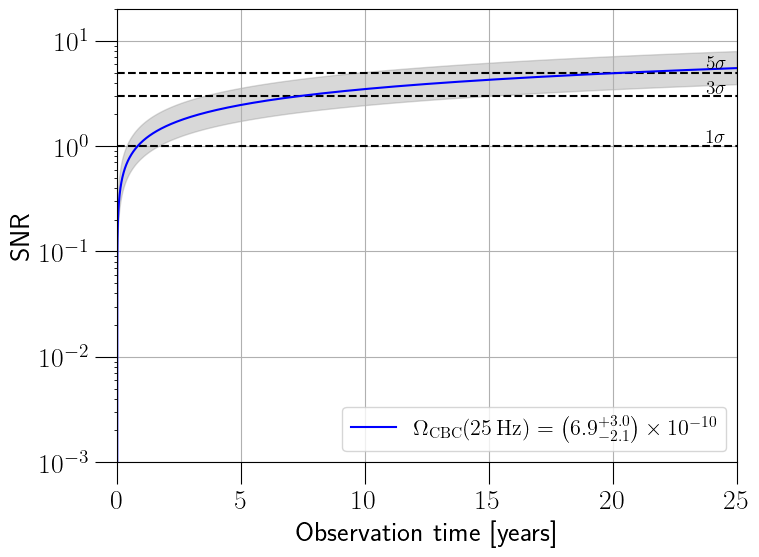

In [35]:
rescaled_obs_time = obs_time/86400/365.25

print(f"For a power law Om_beta({fref})={Om_beta} with spectral index beta = {beta}")
print(f"Reaching SNR = 1 after {(rescaled_obs_time[snr_t>1])[0]*365.25/30.4375} months of observation.")
print(f"Reaching SNR = 3 after {(rescaled_obs_time[snr_t>3])[0]} years of observation.")
print(f"Reaching SNR = 5 after {(rescaled_obs_time[snr_t>5])[0]} years of observation.\n")

print(f"Optimistic scenario: Om_beta({fref})={Om_beta*Om_beta_up_factor} with spectral index beta = {beta}")
print(f"Reaching SNR = 1 after {(rescaled_obs_time[snr_t*Om_beta_up_factor>1])[0]*365.25/30.4375} months of observation.")
print(f"Reaching SNR = 3 after {(rescaled_obs_time[snr_t*Om_beta_up_factor>3])[0]} years of observation.")
print(f"Reaching SNR = 5 after {(rescaled_obs_time[snr_t*Om_beta_up_factor>5])[0]} years of observation.")


plt.plot(rescaled_obs_time, snr_t, color = "blue", label = r"$\Omega_{\mathrm{CBC}}(25\, {\rm Hz}) = \left(6.9^{+3.0}_{-2.1}\right)\times 10^{-10}$")
plt.fill_between(rescaled_obs_time, snr_t*Om_beta_up_factor, snr_t*Om_beta_down_factor, color = "gray", alpha = 0.3)

plt.hlines(1, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(3, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(5, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.annotate(r"$1\sigma$", (rescaled_obs_time[-1]*0.95, 1+0.1), textcoords='data', fontsize=14)
plt.annotate(r"$3\sigma$", (rescaled_obs_time[-1]*0.95, 3+0.2), textcoords='data', fontsize=14)
plt.annotate(r"$5\sigma$", (rescaled_obs_time[-1]*0.95, 5+0.5), textcoords='data', fontsize=14)
#plt.xscale("log")
plt.yscale("log")

plt.xlim(rescaled_obs_time[0], rescaled_obs_time[-1])
plt.ylim(1e-3, 20)
plt.xlabel("Observation time [years]")
plt.ylabel("SNR")
plt.grid()
plt.legend(fontsize = 20*0.8, loc="lower right")
plt.savefig("Predicting_Armageddon_plot_HL_GWTC-3.pdf", bbox_inches = "tight")
plt.show()

## HLV (all aLIGO design PSD)

In [25]:
obs_time = np.append(0, np.logspace(0, np.log10(86400*365.25*25), 1000))#86400*365.25#
Om_beta = 6.9e-10
Om_beta_up_factor = (Om_beta+3.0e-10)/Om_beta
Om_beta_down_factor = (Om_beta-2.1e-10)/Om_beta
beta = 2./3
#print(obs_time)
snr_t = PI_SNR(f_pi, OM_eff_HLV, obs_time = obs_time, fref = fref, beta = beta, Om_beta = Om_beta)
#snr_t = PI_SNR(f_pi, OM_eff_HL_pi/np.sqrt(3), obs_time = obs_time, fref = fref, beta = beta, Om_beta = Om_beta)
#print(snr_t)

In [26]:
rescaled_obs_time = obs_time/86400/365.25

print(f"For a power law Om_beta({fref})={Om_beta} with spectral index beta = {beta}")
print(f"Reaching SNR = 1 after {(rescaled_obs_time[snr_t>1])[0]*365.25/30.4375} months of observation.")
print(f"Reaching SNR = 3 after {(rescaled_obs_time[snr_t>3])[0]} years of observation.")
print(f"Reaching SNR = 5 after {(rescaled_obs_time[snr_t>5])[0]} years of observation.\n")

print(f"Optimistic scenario: Om_beta({fref})={Om_beta*Om_beta_up_factor} with spectral index beta = {beta}")
print(f"Reaching SNR = 1 after {(rescaled_obs_time[snr_t*Om_beta_up_factor>1])[0]*365.25/30.4375} months of observation.")
print(f"Reaching SNR = 3 after {(rescaled_obs_time[snr_t*Om_beta_up_factor>3])[0]} years of observation.")
print(f"Reaching SNR = 5 after {(rescaled_obs_time[snr_t*Om_beta_up_factor>5])[0]} years of observation.")


plt.plot(rescaled_obs_time, snr_t, color = "blue")
plt.fill_between(rescaled_obs_time, snr_t*Om_beta_up_factor, snr_t*Om_beta_down_factor, color = "gray", alpha = 0.3)

plt.hlines(1, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(3, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(5, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.annotate(r"$1\sigma$", (rescaled_obs_time[-1]*0.95, 1+0.1), textcoords='data', fontsize=14)
plt.annotate(r"$3\sigma$", (rescaled_obs_time[-1]*0.95, 3+0.2), textcoords='data', fontsize=14)
plt.annotate(r"$5\sigma$", (rescaled_obs_time[-1]*0.95, 5+0.5), textcoords='data', fontsize=14)
#plt.xscale("log")
plt.yscale("log")

plt.xlim(rescaled_obs_time[0], rescaled_obs_time[-1])
plt.xlabel("Observation time [years]")
plt.ylabel("SNR")
plt.grid()
plt.savefig("Predicting_Armageddon_plot_HLV.pdf", bbox_inches = "tight")
plt.show()

For a power law Om_beta(100.0)=6.9e-10 with spectral index beta = 0.6666666666666666
Reaching SNR = 1 after 56.982212862538134 months of observation.


IndexError: index 0 is out of bounds for axis 0 with size 0

## HLVK  (all aLIGO design PSD)

In [ ]:
obs_time = np.append(0, np.logspace(0, np.log10(86400*365.25*25), 1000))#86400*365.25#
Om_beta = 6.9e-10
Om_beta_up_factor = (Om_beta+3.0e-10)/Om_beta
Om_beta_down_factor = (Om_beta-2.1e-10)/Om_beta
beta = 2./3
#print(obs_time)
snr_t = PI_SNR(f_pi, OM_eff_HLVK, obs_time = obs_time, fref = fref, beta = beta, Om_beta = Om_beta)
#snr_t = PI_SNR(f_pi, OM_eff_HL_pi/(np.sqrt(6)), obs_time = obs_time, fref = fref, beta = beta, Om_beta = Om_beta)

#print(snr_t)

In [ ]:
rescaled_obs_time = obs_time/86400/365.25

print(f"For a power law Om_beta({fref})={Om_beta} with spectral index beta = {beta}")
print(f"Reaching SNR = 1 after {(rescaled_obs_time[snr_t>1])[0]*365.25/30.4375} months of observation.")
print(f"Reaching SNR = 3 after {(rescaled_obs_time[snr_t>3])[0]} years of observation.")
print(f"Reaching SNR = 5 after {(rescaled_obs_time[snr_t>5])[0]} years of observation.\n")

print(f"Optimistic scenario: Om_beta({fref})={Om_beta*Om_beta_up_factor} with spectral index beta = {beta}")
print(f"Reaching SNR = 1 after {(rescaled_obs_time[snr_t*Om_beta_up_factor>1])[0]*365.25/30.4375} months of observation.")
print(f"Reaching SNR = 3 after {(rescaled_obs_time[snr_t*Om_beta_up_factor>3])[0]} years of observation.")
print(f"Reaching SNR = 5 after {(rescaled_obs_time[snr_t*Om_beta_up_factor>5])[0]} years of observation.")


plt.plot(rescaled_obs_time, snr_t, color = "blue")
plt.fill_between(rescaled_obs_time, snr_t*Om_beta_up_factor, snr_t*Om_beta_down_factor, color = "gray", alpha = 0.3)

plt.hlines(1, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(3, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(5, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.annotate(r"$1\sigma$", (rescaled_obs_time[-1]*0.95, 1+0.1), textcoords='data', fontsize=14)
plt.annotate(r"$3\sigma$", (rescaled_obs_time[-1]*0.95, 3+0.2), textcoords='data', fontsize=14)
plt.annotate(r"$5\sigma$", (rescaled_obs_time[-1]*0.95, 5+0.5), textcoords='data', fontsize=14)
#plt.xscale("log")
plt.yscale("log")

plt.xlim(rescaled_obs_time[0], rescaled_obs_time[-1])
plt.xlabel("Observation time [years]")
plt.ylabel("SNR")
plt.grid()
plt.show()

## HLVKI (all aLIGO design PSD)

In [ ]:
obs_time = np.append(0, np.logspace(0, np.log10(86400*365.25*25), 1000))#86400*365.25#
Om_beta = 6.9e-10
Om_beta_up_factor = (Om_beta+3.0e-10)/Om_beta
Om_beta_down_factor = (Om_beta-2.1e-10)/Om_beta
beta = 2./3
#print(obs_time)
snr_t = PI_SNR(f_pi, OM_eff_HLVKI, obs_time = obs_time, fref = fref, beta = beta, Om_beta = Om_beta)
#snr_t = PI_SNR(f_pi, OM_eff_HL_pi/np.sqrt(10), obs_time = obs_time, fref = fref, beta = beta, Om_beta = Om_beta)
#print(snr_t)

In [ ]:
rescaled_obs_time = obs_time/86400/365.25

print(f"For a power law Om_beta({fref})={Om_beta} with spectral index beta = {beta}")
print(f"Reaching SNR = 1 after {(rescaled_obs_time[snr_t>1])[0]*365.25/30.4375} months of observation.")
print(f"Reaching SNR = 3 after {(rescaled_obs_time[snr_t>3])[0]} years of observation.")
print(f"Reaching SNR = 5 after {(rescaled_obs_time[snr_t>5])[0]} years of observation.\n")

print(f"Optimistic scenario: Om_beta({fref})={Om_beta*Om_beta_up_factor} with spectral index beta = {beta}")
print(f"Reaching SNR = 1 after {(rescaled_obs_time[snr_t*Om_beta_up_factor>1])[0]*365.25/30.4375} months of observation.")
print(f"Reaching SNR = 3 after {(rescaled_obs_time[snr_t*Om_beta_up_factor>3])[0]} years of observation.")
print(f"Reaching SNR = 5 after {(rescaled_obs_time[snr_t*Om_beta_up_factor>5])[0]} years of observation.")


plt.plot(rescaled_obs_time, snr_t, color = "blue")
plt.fill_between(rescaled_obs_time, snr_t*Om_beta_up_factor, snr_t*Om_beta_down_factor, color = "gray", alpha = 0.3)

plt.hlines(1, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(3, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(5, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.annotate(r"$1\sigma$", (rescaled_obs_time[-1]*0.95, 1+0.1), textcoords='data', fontsize=14)
plt.annotate(r"$3\sigma$", (rescaled_obs_time[-1]*0.95, 3+0.2), textcoords='data', fontsize=14)
plt.annotate(r"$5\sigma$", (rescaled_obs_time[-1]*0.95, 5+0.5), textcoords='data', fontsize=14)
#plt.xscale("log")
plt.yscale("log")

plt.xlim(rescaled_obs_time[0], rescaled_obs_time[-1])
plt.xlabel("Observation time [years]")
plt.ylabel("SNR")
plt.grid()
plt.show()

In [ ]:
print(np.shape(OM_eff_HL_pi), np.shape(OM_eff_HLV), np.shape(f_pi))
print(OM_eff_HL_pi[10], OM_eff_HLV[10], OM_eff_HLVK[10], OM_eff_HLVKI[10],  np.shape(f_pi))